# LiBol Workflow v1

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import shapely


import os

import flopy

import flopy.utils.binaryfile as bf

from osgeo import gdal
import flopy.modflow as mf

# import arcpy as ap
import wradlib as wrl

C:\Users\aghug\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


flopy is installed in C:\Users\aghug\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


### Set working directory

In [4]:
Directory = os.getcwd()
os.path.exists(Directory)

True

### Load MODFLOW model

In [5]:
fpath = os.path.join('LiBol-WF-UTM-04.nam')
os.path.exists(fpath)

ml = flopy.modflow.Modflow()
ml = flopy.modflow.Modflow.load(fpath)
ml.check()



LiBol-WF-UTM-04 MODEL DATA VALIDATION SUMMARY:
  41 Warnings:
    DRN package: BC in inactive cell
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS
    RCH package: Variable NRCHOP set to value other than 3

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker 

### Get package list

In [6]:
ml.get_package_list()

['DIS', 'BAS6', 'LPF', 'PCG', 'RCH', 'DRN', 'OC']

### Add the drain package (DRN)

#### There are two ascii gridded files defining the locations and elevations of the river nodes. The information needs to be converted into a list.

In [7]:
# Read river node locations
river = np.loadtxt(Directory+"/ProjectedPoints.asc", skiprows=6)
river = np.asarray(river)
river.shape[1]

# Read ztop information
ztop = np.loadtxt(Directory+"/PointMeanValues.asc", skiprows=6)
ztop = np.asarray(ztop)

# Create drains from ascii grid maps 
M = []
for i in range(river.shape[0]):
    for q in range(river.shape[1]):
        if river[i,q] == 1:
            M.append([0,i,q,ztop[i,q],100]) #layer,row,column,elevation(float),conductance
            
            
# Read the fixed head file and memorise as a list file 
ListFile =  np.loadtxt(Directory+"/Libol-WF-UTM-04.chd", skiprows=3)

RowValues=ListFile[:,1]
ColValues=ListFile[:,2]

for i in range(len(ListFile)):
    RowVal = int(RowValues[i])
    ColVal = int(ColValues[i])
    M.append([0,RowVal,ColVal,3650,100]) #layer,row,column,elevation(float),conductance

rivDrn = {0:M}

# Add package to the model
drn = flopy.modflow.ModflowDrn(ml, ipakcb=9, unitnumber=43, stress_period_data=rivDrn)            


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdrn.ModflowDrn'> <class 'flopy.modflow.mfdrn.ModflowDrn'>
replacing existing Package...


#### Adjust the hydraulic conductivity values 

In [9]:
ZoneNbrs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-9999]
# Hyd=[0.00001,0.0001,0.0001,0.0001,0.01,0.001,0.01,0.01,0.0001,0.0001,0.1,0.01,0.001,0.01,0.1,1.,0.]
Hyd=[0.1,0.5,0.5,0.5,0.5,0.5,5.0,0.5,0.5,0.5,5,5,0.5,5.0,5.0,20.0,0.]
Por=[0.2,0.2,0.2,0.2,0.25,0.01,0.25,0.25,0.03,0.2,0.25,0.25,0.1,0.3,0.3,0.2,0.]
ZoneNbrs=pd.DataFrame(ZoneNbrs, columns=['ZoneNbrs'])
Hyd=pd.DataFrame(Hyd, columns=['Hyd'])
Por=pd.DataFrame(Por, columns=['Por'])
Table=pd.concat([ZoneNbrs,Hyd,Por],axis=1)
#Table.set_index('ZoneNbrs')


In [10]:
# Read zones
zones = np.loadtxt(Directory+"/geolzonesnumfull.txt", skiprows=6)
zones = np.asarray(zones)
zones

# Create array of floats (nlay, nrow, ncol)) hydraulic conductivity values  
Kh=np.zeros((zones.shape[0], zones.shape[1]))
for i in range(zones.shape[0]):
    for q in range(zones.shape[1]):
        Val = Table.Hyd.loc[Table['ZoneNbrs']==zones[i,q]] 
        Kh[i,q]=Val


In [11]:
lpf = mf.ModflowLpf(ml,ipakcb=9 ,hk=Kh)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...


In [12]:
Kh

array([[5., 5., 5., ..., 0., 0., 0.],
       [5., 5., 5., ..., 0., 0., 0.],
       [5., 5., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Write files of the MODFLOW model

In [13]:
ml.write_input()

In [14]:
ml.run_model()

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: LiBol-WF-UTM-04.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/11/09 17:10:20

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/11/09 17:10:22
 Elapsed run time:  2.102 Seconds

  Normal termination of simulation


(True, [])

### Model grid and heads representation

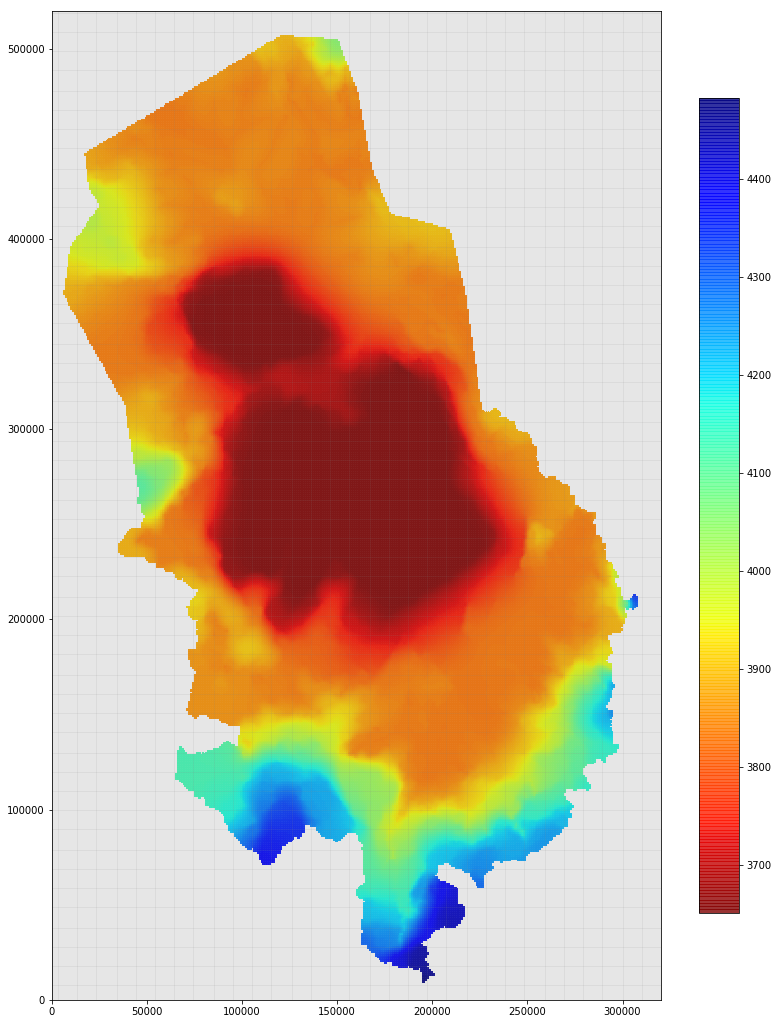

In [8]:
fname = os.path.join(Directory, 'LiBol-WF-UTM-04.hds')


hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
hdobj.times

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=ml, layer = 0)
#quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[-2.e+20], alpha=0.8,cmap='jet_r')
#modelmap.contour_array(head, masked_values=[-2.e+20])
#handles, labels = ax.get_legend_handles_labels()

linecollection = modelmap.plot_grid(linewidth=0.2)

plt.colorbar(quadmesh, shrink=0.5)

FigFName=Directory+'/ModelGrid_Heads.png'
FigFName
fig.savefig(FigFName,bbox_inches='tight')



In [39]:
print(hdobj.times)
print(head)
ncols = len(head[0][0])
nrows = len(head[0])
print(len(head[0][0]), ncols)
print(len(head[0]), nrows)

# try anpther plot

# hdobj.plot(totim=1.0, contour=True, grid=False, colorbar=True, figsize=(10, 10));

# write to shapefile

# hdobj.to_shapefile(os.path.join(Directory, "freyburg_head.shp"))

FigASCName=Directory+'/ModelGrid_Heads'
FigASCName
# flopy.export.utils.export_array(ml.grid, FigASCName, head, nodata=-9999, fieldname='value',)

print(Directory)
HeadsFile=open(Directory+"\heads.asc","w")
HeadsFile.write("ncols 320\n")
HeadsFile.write("nrows 520\n")
HeadsFile.write("xllcorner     485000\n")
HeadsFile.write("yllcorner     7499500\n")
HeadsFile.write("cellsize      1000\n")
HeadsFile.write("NODATA_value  -2e+20\n")
for rowcount in range(nrows):
    for colcount in range(ncols):
        HeadValue = head[0][rowcount-1][colcount-1]
        HeadsFile.write(str(HeadValue)+" ")
    HeadsFile.write("\n")
HeadsFile.close()

[1.0]
[[[-2.e+20 -2.e+20 -2.e+20 ... -2.e+20 -2.e+20 -2.e+20]
  [-2.e+20 -2.e+20 -2.e+20 ... -2.e+20 -2.e+20 -2.e+20]
  [-2.e+20 -2.e+20 -2.e+20 ... -2.e+20 -2.e+20 -2.e+20]
  ...
  [-2.e+20 -2.e+20 -2.e+20 ... -2.e+20 -2.e+20 -2.e+20]
  [-2.e+20 -2.e+20 -2.e+20 ... -2.e+20 -2.e+20 -2.e+20]
  [-2.e+20 -2.e+20 -2.e+20 ... -2.e+20 -2.e+20 -2.e+20]]]
320 320
520 520
C:\Users\aghug\Desktop\Li Br\Innovate-UK LiBol\MODFLOW\LibolClean


### Active/inactive cells on model extension

C:\Users\majm\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy\plot\map.py:1643: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


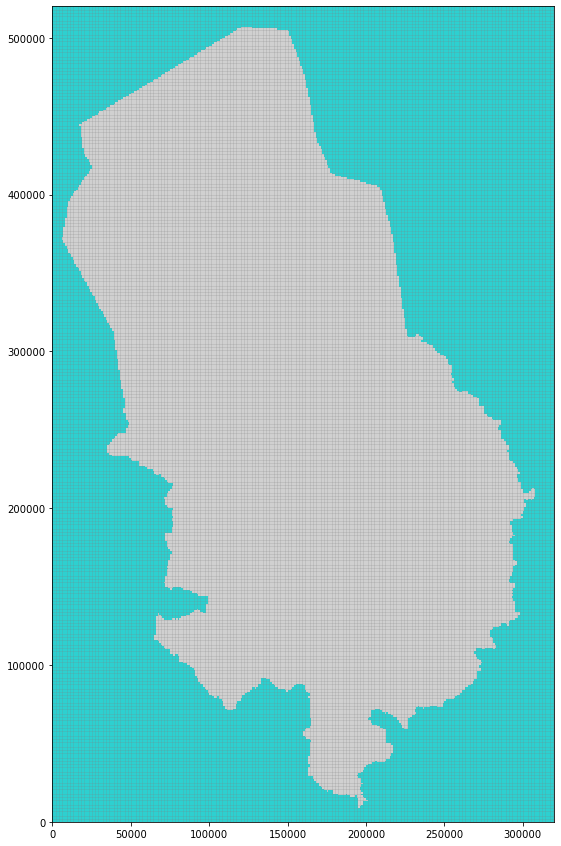

In [17]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=0)
quadmesh = modelmap.plot_ibound(color_noflow='cyan')
#quadmesh = modelmap.plot_array(EVTR, masked_values=[0], alpha=0.8,cmap='jet_r')

linecollection = modelmap.plot_grid(linewidth=0.4)

FigFName=Directory+'/ModelGridActive.png'
FigFName
fig.savefig(FigFName,bbox_inches='tight')

### Channel network as drain (DRN) package

C:\Users\aghug\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy\plot\map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


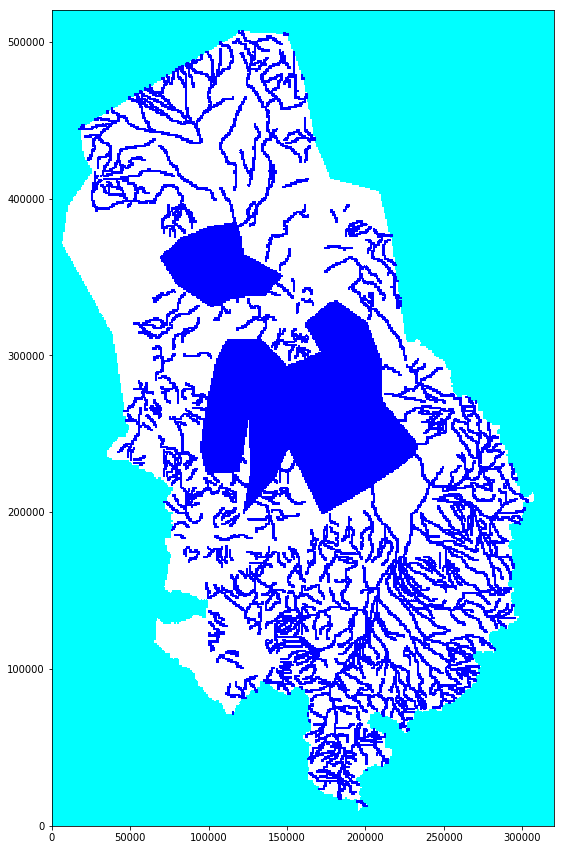

In [18]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=0)
quadmesh = modelmap.plot_ibound(color_noflow='cyan')
quadmesh = modelmap.plot_bc('DRN', color='blue')
#quadmesh = modelmap.plot_array(EVTR, masked_values=[0], alpha=0.8,cmap='jet_r')

#linecollection = modelmap.plot_grid(linewidth=0.4)

FigFName=Directory+'/ModelRiversAndFH.png'
FigFName
fig.savefig(FigFName,bbox_inches='tight')


### Load libraries for ModPath

In [13]:
#class Modpath7(modelname='modpath7test', simfile_ext='mpsim', namefile_ext='mpnam', version='modpath7', exe_name='mp7.exe', flowmodel=None, headfilename=None, budgetfilename=None, model_ws=None, verbose=False)
mp = flopy.modpath.Modpath7('LiBol-WF-UTM-04', exe_name='mpath7',flowmodel=ml)

In [14]:
# Set the porosity array
# Read zones
zones = np.loadtxt(Directory+"/geolzonesnumfull.txt", skiprows=6)
zones = np.asarray(zones)
zones

# Create array of floats (nlay, nrow, ncol)) hydraulic conductivity values  
n=np.zeros((zones.shape[0], zones.shape[1]))
for i in range(zones.shape[0]):
    for q in range(zones.shape[1]):
        Val = Table.Por.loc[Table['ZoneNbrs']==zones[i,q]] 
        n[i,q]=Val

In [15]:
n

array([[0.3, 0.3, 0.3, ..., 0. , 0. , 0. ],
       [0.3, 0.3, 0.3, ..., 0. , 0. , 0. ],
       [0.3, 0.3, 0.3, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [17]:
#class Modpath7Bas(model, porosity=0.3, defaultiface=None, extension='mpbas')
mpsimmpbas = flopy.modpath.Modpath7Bas(mp, porosity=n)

****Warning -- two packages of the same type:  <class 'flopy.modpath.mp7bas.Modpath7Bas'> <class 'flopy.modpath.mp7bas.Modpath7Bas'>
replacing existing Package...


In [38]:
#class ParticleData(partlocs=None, structured=False, particleids=None, localx=None, localy=None, localz=None, timeoffset=None, drape=None)
#class ParticleGroup(particlegroupname='PG1', filename=None, releasedata=0.0, particledata=None)

# X=np.arange(2,320,10)
# Y=np.arange(2,520,10)
X=np.arange(2,320,5)
Y=np.arange(280,520,5)
Xs=np.tile(X,len(Y))
Ys=np.repeat(Y,len(X))
Zs=np.repeat(0,len(Xs))
locs=list(zip(Zs,Ys,Xs))

#locs = [(0, 200, 210), (0, 220, 220),(0, 300, 210), (0, 320, 220)]
pd = flopy.modpath.ParticleData(locs, structured=True, drape=0, localx=0.5, localy=0.5, localz=1.0)
pg = flopy.modpath.ParticleGroup(particledata=pd)

In [39]:
#class Modpath7Sim(model, mpnamefilename=None, listingfilename=None, endpointfilename=None, pathlinefilename=None, 
# timeseriesfilename=None, tracefilename=None, simulationtype='pathline', trackingdirection='forward', 
# weaksinkoption='stop_at', weaksourceoption='stop_at', budgetoutputoption='no', traceparticledata=None, 
# budgetcellnumbers=None, referencetime=None, stoptimeoption='extend', stoptime=None, timepointdata=None, 
# zonedataoption='off', stopzone=None, zones=0, retardationfactoroption='off', retardation=1.0, 
# particlegroups=None, extension='mpsim')

mpsim = flopy.modpath.Modpath7Sim(mp,simulationtype='combined',weaksinkoption='pass_through',particlegroups=pg)

****Warning -- two packages of the same type:  <class 'flopy.modpath.mp7sim.Modpath7Sim'> <class 'flopy.modpath.mp7sim.Modpath7Sim'>
replacing existing Package...


In [40]:
mp.write_input()

In [41]:
mp.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mpath7.EXE

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1499 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
      1573 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

### Write pathlines to a shapefile

In [42]:
# End data Object
endobj = flopy.utils.EndpointFile('LiBol-WF-UTM-04.mpend')

# Get endpoint data from the endpoint file for one endpoint
e1 = endobj.get_data(partid=1)

# Get endpoint data from the endpoint file for all endpoints
e = endobj.get_alldata()

e1



rec.array([(1, 0, 1, 7, 0., 0., 89607, 0, 0.5, 0.5, 1., 7500., 239500., 0., 0, 6, 89607, 0, 0.5, 0.5, 1., 7500., 239500., 0., 0, 6)],
          dtype=[('particleid', '<i4'), ('particlegroup', '<i4'), ('particleidloc', '<i4'), ('status', '<i4'), ('time0', '<f4'), ('time', '<f4'), ('node0', '<i4'), ('k0', '<i4'), ('xloc0', '<f4'), ('yloc0', '<f4'), ('zloc0', '<f4'), ('x0', '<f4'), ('y0', '<f4'), ('z0', '<f4'), ('zone0', '<i4'), ('initialcellface', '<i4'), ('node', '<i4'), ('k', '<i4'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('zone', '<i4'), ('cellface', '<i4')])

In [45]:
endobj.write_shapefile(e,direction='ending',shpname='test_ptlces',epsg=32719,sr=ml.sr)

   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
wrote test_ptlces


In [46]:
pathobj = flopy.utils.PathlineFile('LiBol-WF-UTM-04.mppth')

pl = pathobj.get_alldata()

pathobj.write_shapefile(pl,pathline_date=None,one_per_particle=True,direction='ending',shpname='test_path_ptlces',mg=None,epsg=32719,sr=ml.sr,)

(numpy.record, [('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('time', '<f4'), ('k', '<i4'), ('particleid', '<i4')])
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
wrote test_path_ptlces


C:\Users\aghug\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy\plot\map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


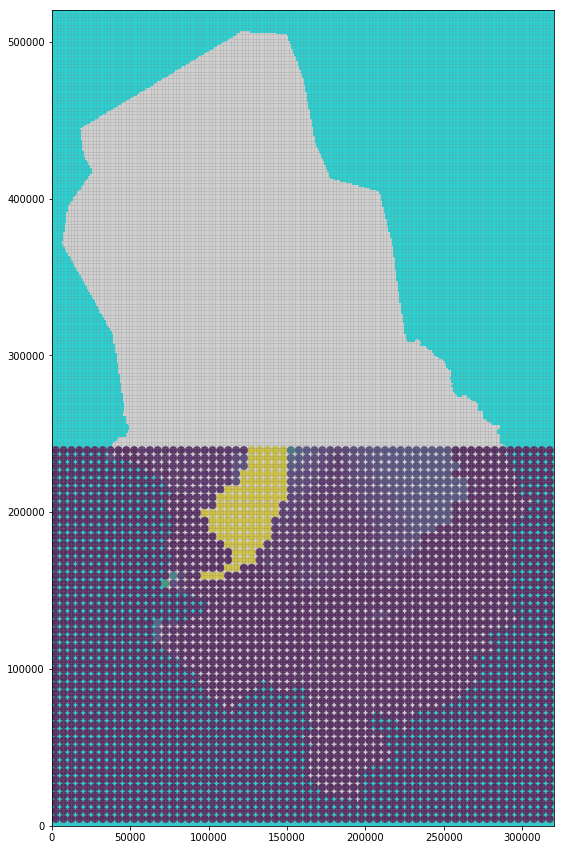

In [44]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=0)
quadmesh = modelmap.plot_ibound(color_noflow='cyan')
#quadmesh = modelmap.plot_array(EVTR, masked_values=[0], alpha=0.8,cmap='jet_r')

linecollection = modelmap.plot_grid(linewidth=0.4)

modelmap.plot_endpoint(e, direction='starting', colorbar=False)

In [27]:
# Pathline Object
pthobj = flopy.utils.PathlineFile('LiBol-WF-UTM-04.mppth')

# get pathline data from the pathline file for one point and all times
p1 = pthobj.get_data(partid=100)

# get pathline data from the pathline file for all pathlines and all times
p = pthobj.get_alldata()

C:\Users\aghug\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy\plot\map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


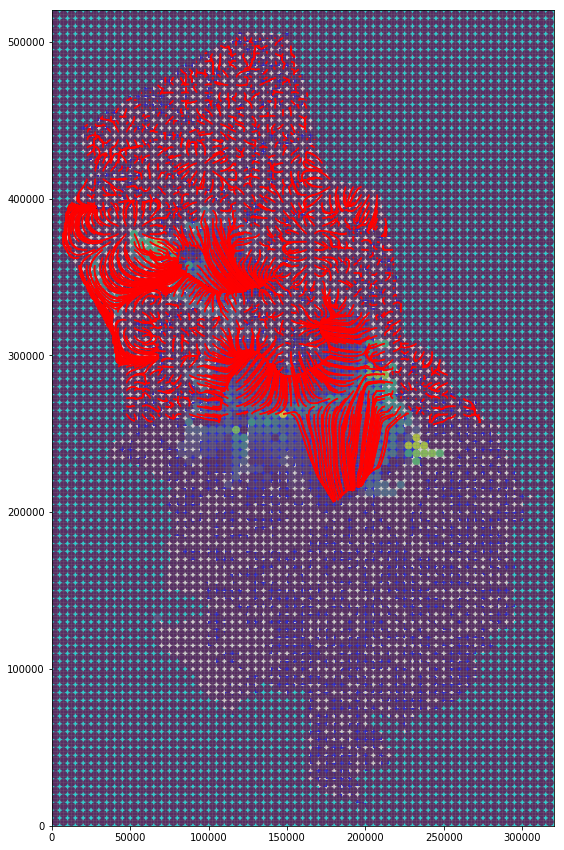

In [131]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=0)
quadmesh = modelmap.plot_ibound(color_noflow='cyan')
quadmesh = modelmap.plot_bc('DRN', color='blue')

linecollection = modelmap.plot_grid(linewidth=0.4)

modelmap.plot_endpoint(e, direction='starting', colorbar=False)

for pid in range(len(p)):
    modelmap.plot_pathline(pthobj.get_data(pid), layer='all', colors='red');